In [192]:
from tqdm import tqdm
import time
import jax
import jax.nn as jnn
import jax.numpy as jnp
from sklearn.preprocessing import StandardScaler
import diffrax
from flax import linen as nn
from typing import Sequence, Dict, Any
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from interpolation import ZOHInterpolation
import nonlinear_benchmarks
import nonlinear_benchmarks.error_metrics as metrics
import equinox as eqx  # https://github.com/patrick-kidger/equinox

In [193]:
%matplotlib widget

In [194]:
seed = 12346
key = jax.random.PRNGKey(seed)
fkey, gkey = jax.random.split(key, 2)

In [195]:
train_val, test = nonlinear_benchmarks.Cascaded_Tanks(atleast_2d=True)
sampling_time = train_val.sampling_time
u_train, y_train = train_val

In [196]:
# Rescale data
scaler_u = StandardScaler()
u = scaler_u.fit_transform(u_train).astype(jnp.float32)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_train).astype(jnp.float32)

t = jnp.arange(0.0, u.shape[0]) * sampling_time


In [197]:
nx = 2
nu = u.shape[-1]
ny = y.shape[-1]

In [198]:
class StateUpdateMLP(eqx.Module):
    mlp: eqx.nn.MLP
    scale: float = 1e-3

    def __init__(self, nx, nu, width, depth, *, scale, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(nx + nu, nx, width, depth, jnn.tanh, key=key)
        self.scale = scale

    def __call__(self, x, u, args):
        dx = self.scale * self.mlp(jnp.r_[x, u])
        return dx  
    

class ChannelSelector(eqx.Module):
    features: Sequence[int]
    def __init__(self, features):
        super().__init__()
        self.features = features
    def __call__(self, x):
        return x[..., self.features]
    
        
class NeuralODE(eqx.Module):
    f_xu: StateUpdateMLP
    g_x: eqx.Module

    def __init__(self, f_xu, g_x):
        super().__init__()
        self.f_xu = f_xu
        self.g_x = g_x

    def __call__(self, ts, us, x0):

        u_fun = ZOHInterpolation(ts=ts, ys=us.ravel()) # input interpolation function

        def vector_field(t, x, args):
            ut = u_fun.evaluate(t)[..., None] # u interpolated at time t
            dx = self.f_xu(x, ut, args)
            return dx
    
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(vector_field),
            #diffrax.Tsit5(),
            #diffrax.Euler(),
            diffrax.Dopri5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=x0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
            max_steps=10_000
        )
        x_sim = solution.ys
        return jax.vmap(self.g_x)(x_sim)

In [199]:
f_xu = StateUpdateMLP(nx, nu, 32, 2, scale=1e-3, key=fkey)
g_x = eqx.nn.MLP(nx, ny, 16, 1, jnn.tanh, key=gkey)
#g_x = ChannelSelector([0])
simulator = NeuralODE(f_xu, g_x)
#simulator(ts, u, jnp.zeros(nx))

In [200]:
x0 = jnp.zeros(nx)
opt_variables = [simulator, x0]

@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_grad_fn(opt_variables, ts, us, ys):
    simulator, x0 = opt_variables
    y_pred = simulator(ts, us, x0)
    return jnp.mean((ys - y_pred) ** 2)

#loss_grad_fn(opt_variables, ts, u, x0)

In [201]:
# Setup optimizer
optimizer = optax.adam(learning_rate=1e-4)
opt_state = optimizer.init(eqx.filter(opt_variables, eqx.is_inexact_array))

In [202]:
# Training loop
time_start = time.time()
LOSS = []
epochs = 20_000
for epoch in (pbar := tqdm(range(epochs))):
    loss_val, grads = loss_grad_fn(opt_variables, t, u, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    opt_variables = eqx.apply_updates(opt_variables, updates)
    LOSS.append(loss_val)
    if epoch % 100 == 0:
        pbar.set_postfix_str(f"Loss step {epoch}: {loss_val}")
    #print()

train_time = time.time() - time_start
print(f"Training time: {train_time:.2f}")

100%|██████████| 20000/20000 [00:56<00:00, 351.51it/s, Loss step 19900: 0.05687127262353897] 

Training time: 56.94


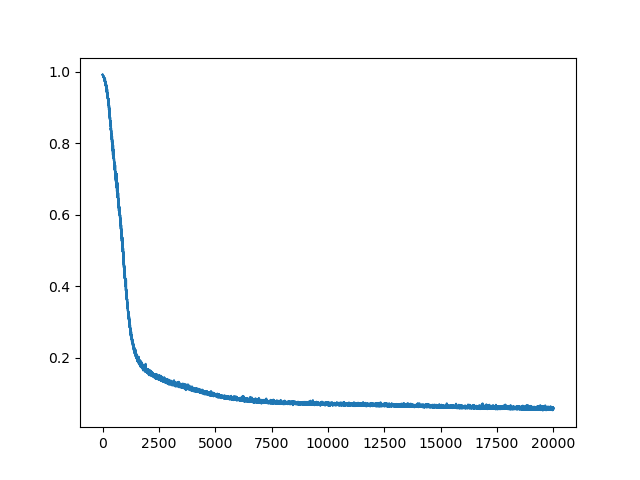

In [203]:
plt.figure()
plt.plot(LOSS)

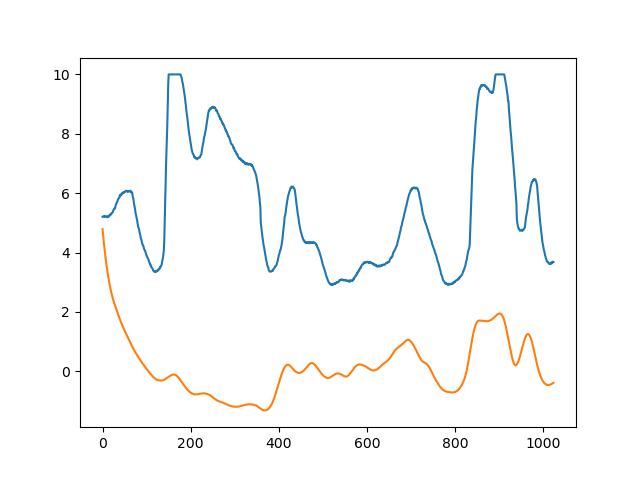

In [206]:
#u_test, y_test = train_val
u_test, y_test = test
u_test = scaler_u.transform(u_test).astype(jnp.float32)


simulator, x0 = opt_variables
y_sim = scaler_y.inverse_transform(simulator(ts, u_test, x0))
plt.figure()
plt.plot(y_test)
plt.plot(y_sim)